<a href="https://colab.research.google.com/github/as2c/MLP---Cosmology/blob/NewData/Optimization2/LogisticReg_data2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this code, our objective is to train some classic models such as SVM, KNN, RandomForest, etc on our test data, and try to evaluate their efficiency by plotting confusion matrixes, learning curves, validation curves, and measuring the prediction time. 

# Import phase I data

Import required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import timeit
import time
%alias_magic t timeit
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Gadget 2 Data / with Neutrino

In [3]:
data = pd.read_csv(r'/content/drive/MyDrive/denc_Neutrino')
# data['in_halo'] = (data['haloID']>0).astype('int')
data['in_halo'] = (data['halo_mass']>1600).astype('int32')
data

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
0,10156552,755,2280.0,171.21194,220.56293,-274.228700,-0.084922,-0.052028,-0.042415,-0.028087,-0.024984,-0.018675,-0.016231,-0.011940,-0.010111,1
1,11068486,85,1539.0,-129.84116,92.60424,212.125500,-0.127820,-0.081099,-0.051217,-0.028345,-0.013751,-0.013991,-0.012344,-0.011500,-0.012220,0
2,9530036,654,1944.0,-290.99210,-885.49430,468.255040,-0.078978,-0.052806,-0.030027,-0.011704,0.001295,0.003803,0.005131,0.005231,0.003787,1
3,11455022,752,1394.0,-60.35258,422.43716,79.394300,-0.109989,-0.079155,-0.054663,-0.037685,-0.026670,-0.017901,-0.009227,-0.000868,0.001568,0
4,8591034,356,1649.0,403.66608,345.88077,9.231552,-0.084405,-0.019068,-0.009396,-0.001539,0.002288,0.005629,0.011288,0.013111,0.013433,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2160800,451,2634.0,654.82430,210.78130,255.344150,-0.094225,-0.076043,-0.060624,-0.040368,-0.020840,-0.016261,-0.011803,-0.005002,0.000918,1
99996,3257728,43,1112.0,-154.27774,488.65564,-779.558400,-0.127045,-0.076529,-0.056246,-0.038201,-0.027520,-0.016374,-0.008045,0.002627,0.006124,0
99997,6101605,484,1198.0,-113.51735,68.44336,275.964000,-0.122135,-0.091794,-0.063465,-0.032060,-0.017973,-0.016684,-0.017740,-0.017154,-0.012600,0
99998,4576456,44,1058.0,-130.21120,292.63483,-754.563000,-0.097585,-0.076140,-0.061788,-0.054584,-0.043055,-0.032415,-0.021591,-0.007463,0.004673,0


In [4]:
data.describe()

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,8.716004e+06,424.627710,2369.299450,35.207601,-13.728656,97.821939,-0.107338,-0.062074,-0.038666,-0.025951,-0.017900,-0.011968,-0.007224,-0.003341,-0.000224,0.557930
std,3.549230e+06,230.962533,1856.527585,364.820655,369.919751,373.578625,0.020301,0.020965,0.019921,0.018106,0.015956,0.013969,0.012346,0.011069,0.010084,0.496635
min,2.131444e+06,16.000000,241.000000,-1247.932500,-1462.806300,-1250.519700,-0.127820,-0.099572,-0.083351,-0.072824,-0.065316,-0.058751,-0.050519,-0.043771,-0.038371,0.000000
25%,5.953820e+06,238.000000,1194.000000,-226.284345,-254.656135,-145.829085,-0.124202,-0.077891,-0.052474,-0.038510,-0.028860,-0.021233,-0.015384,-0.010712,-0.006964,0.000000
50%,9.043250e+06,418.000000,1791.000000,32.857450,-4.815737,101.883413,-0.113607,-0.063404,-0.039434,-0.026100,-0.017784,-0.011980,-0.007369,-0.003743,-0.000713,1.000000
75%,1.176120e+07,619.000000,2945.000000,284.168098,238.543252,350.062135,-0.095776,-0.048722,-0.025370,-0.013587,-0.006677,-0.002087,0.001081,0.004249,0.006694,1.000000
max,1.464652e+07,870.000000,10101.000000,1314.092800,1256.822900,1355.984900,0.017155,0.032463,0.044346,0.040490,0.042179,0.036009,0.033482,0.034145,0.032602,1.000000


### Define Datasets

In [5]:
## Neutrino
X = data.iloc[:,3:15].astype('float32').values
Y = data.in_halo.astype('int32').values

In [6]:
## Scale / Neutrino
X = (X - np.mean(X))/np.std(X)

In [7]:
## Split into test and train / Neutrino

tst_size = 0.2
ns, nf = np.shape(X) 
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X, Y, n_samples = ns, random_state=0) , random_state=0, test_size =tst_size )
print('X_train :',len(X_train),'   X_test :',len(X_test))

X_train : 80000    X_test : 20000


In [8]:
# Frequency of 1-class / Neutrino
print("{} % of the stored data has class 1 ".format(100*Y.sum()/len(Y)))

55.793 % of the stored data has class 1 


## Gadget 2 Data / without Neutrino

In [5]:
data_cdm = pd.read_csv(r'/content/drive/MyDrive/denc_CDM')
data_cdm['in_halo'] = (data_cdm['halo_mass']>1600).astype('int32')
data_cdm

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
0,8981131,414,1504.0,252.710050,-464.239500,509.94550,2.817576,2.780794,2.746420,2.446413,2.000415,1.533108,1.083378,0.691070,0.457584,0
1,9901676,1026,1013.0,-167.701370,499.161740,156.32635,2.690323,2.102417,1.805493,1.485764,1.267945,1.083753,0.849938,0.617267,0.431845,0
2,8288987,1079,727.0,46.129280,19.954561,164.61870,1.010590,0.821528,0.559744,0.220796,0.003400,-0.094805,-0.074599,0.003315,0.076079,0
3,4842631,675,1268.0,-234.629320,349.021400,-690.46674,1.889611,1.180236,0.495534,0.064434,-0.232441,-0.389582,-0.407908,-0.334146,-0.231578,0
4,12884124,437,6128.0,146.780670,-180.209270,-558.39777,2.676619,1.734870,0.906903,0.464721,0.187801,0.057663,0.029529,0.049055,0.101472,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,12466311,1085,5542.0,25.253933,-580.586850,113.06337,1.482403,1.068278,0.857863,0.583947,0.327563,0.212553,0.139374,0.103515,0.090791,1
99996,11857185,491,691.0,-423.371550,138.109020,-300.80450,-0.209077,-0.534490,-0.724460,-0.749430,-0.743152,-0.663805,-0.511928,-0.347015,-0.253660,0
99997,9340191,947,868.0,225.385210,-9.085627,318.22006,1.086942,0.492283,0.114506,-0.050883,-0.161068,-0.168421,-0.159639,-0.175261,-0.202931,0
99998,13317963,1034,1175.0,-55.431606,16.332230,-898.90326,0.339088,-0.085185,-0.248881,-0.328230,-0.343797,-0.306353,-0.275684,-0.282089,-0.284524,0


In [6]:
data_cdm.describe()

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,8.533738e+06,633.075900,3004.391080,32.287533,-13.697343,89.574071,1.423915,1.032233,0.712873,0.480862,0.322917,0.216223,0.144046,0.096634,0.066060,0.589200
std,3.598448e+06,358.496156,2802.876192,359.880883,364.383569,374.571567,1.023549,0.920945,0.807251,0.689640,0.585773,0.502089,0.436403,0.384151,0.341271,0.491981
min,2.131195e+06,3.000000,271.000000,-1234.874100,-1571.376600,-1311.024700,-0.994127,-0.912349,-0.878283,-0.891915,-0.933043,-0.935449,-0.868262,-0.815454,-0.787467,0.000000
25%,5.640789e+06,368.000000,1181.000000,-223.982345,-249.685410,-148.388917,0.660156,0.354545,0.122621,-0.026842,-0.107359,-0.161173,-0.183527,-0.186967,-0.181568,0.000000
50%,8.790886e+06,676.000000,2020.000000,28.124724,-4.978945,97.944227,1.269011,0.890765,0.589027,0.370513,0.223129,0.134561,0.074502,0.037988,0.011761,1.000000
75%,1.143724e+07,970.000000,3662.000000,277.156240,231.618633,341.305498,2.057976,1.549992,1.162333,0.872826,0.674880,0.526476,0.422276,0.353801,0.294427,1.000000
max,1.464654e+07,1251.000000,31252.000000,1362.093800,1185.835400,1349.211900,5.624963,4.721646,3.972765,3.400808,2.783131,2.163220,1.888203,1.618024,1.364662,1.000000


### Define Datasets

In [8]:
X2 = data_cdm.iloc[:,3:15].astype('float32').values
Y2 = data_cdm.in_halo.astype('int32').values

In [10]:
## Scale
X2 = (X2 - np.mean(X2))/np.std(X2)

In [12]:
## Split into test and train

tst_size = 0.2
ns, nf = np.shape(X) 
X2_train, X2_test, Y2_train, Y2_test = train_test_split(*shuffle(X, Y, n_samples = ns, random_state=0) , random_state=0, test_size =tst_size )
print('X2_train :',len(X2_train),'   X2_test :',len(X2_test))

X2_train : 80000    X2_test : 20000


In [14]:
# Frequency of 1-class / CDM
print("{} % of the stored data has class 1 ".format(100*Y2.sum()/len(Y2)))

58.92 % of the stored data has class 1 


# Logistic Regression

Training a linear logistic regression with intercepts on a 1st degree polynpmial of sample data, in pipeline.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

deg = 3

lrg = LogisticRegression(fit_intercept=True, penalty='l2', max_iter=300, C = 1, tol=.01, solver='lbfgs')
clf = Pipeline([('scaler', StandardScaler() ), 
                        ('p_transformer', PolynomialFeatures(degree = deg)), 
                        ('clf', lrg)])

clf.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [15]:
# F1 score on the test set
from sklearn.metrics import f1_score

f1_score(Y_test, Y_predict, average='macro')

0.7292486713109956

### Fine Tuning The Hyperparameter

In [41]:
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'p_transformer', 'clf', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'p_transformer__degree', 'p_transformer__include_bias', 'p_transformer__interaction_only', 'p_transformer__order', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__l1_ratio', 'clf__max_iter', 'clf__multi_class', 'clf__n_jobs', 'clf__penalty', 'clf__random_state', 'clf__solver', 'clf__tol', 'clf__verbose', 'clf__warm_start'])

In [24]:
from sklearn.model_selection import GridSearchCV

# deg_list = [1,2,3]

tol = np.logspace(-3,-1, num=3)

# penalty = ['l1', 'l2']

# class_weight = [{0: 5, 1:1}, {0: 3, 1:1}, None]

C = [.1,1]

solver = ['lbfgs', 'saga']

random_grid_lrg = {
                # 'clf__class_weight': class_weight,
                'clf__solver': solver,
                # 'p_transformer__degree' : deg_list,
                'clf__C': C,
                'clf__tol': tol
                  }

print(random_grid_lrg)

{'clf__solver': ['lbfgs', 'saga'], 'clf__C': [0.1, 1], 'clf__tol': array([0.001, 0.01 , 0.1  ])}


In [ ]:
scoring = 'f1'
best_params= []
print('start')

lrg_grid = GridSearchCV(estimator = clf, param_grid = random_grid_lrg, scoring= scoring, cv = 4, verbose=2, pre_dispatch=2)


lrg_grid.fit(X_train, Y_train)

best_params += [lrg_grid.best_params_]
print(best_params)

In [ ]:
# Other best_params we got:
# accuracy:
## {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'saga', 'p_transformer__degree': 1}
## {'clf__C': 1, 'clf__solver': 'liblinear', 'p_transformer__degree': 1}
## {'clf__C': 0.1,'clf__class_weight': None,'clf__solver': 'liblinear','p_transformer__degree': 1}
#  f1:
## [{'clf__C': 0.1, 'clf__solver': 'lbfgs', 'clf__tol': 0.001}]
## [{'clf__C': 1, 'clf__class_weight': {0: 1, 1: 3}, 'clf__solver': 'lbfgs', 'p_transformer__degree': 2}]
## {'clf__C': 1, 'clf__class_weight': {0: 1, 1: 5}, 'clf__solver': 'liblinear', 'p_transformer__degree': 1}

Best Model:

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
deg = 4

lrg = LogisticRegression(fit_intercept=True, penalty='l2', max_iter=400, C=.1, tol=.001, solver='lbfgs')
clf = Pipeline([('scaler', StandardScaler() ), 
                        ('p_transformer', PolynomialFeatures(degree = deg)), 
                        ('clf', lrg)])

In [10]:
clf.fit(X_train, Y_train)
Y_predict = clf.predict(X_test)

# F1 score on the test set
from sklearn.metrics import f1_score
f1_score(Y_test, Y_predict, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.7542484503763625

### Learning Curve

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


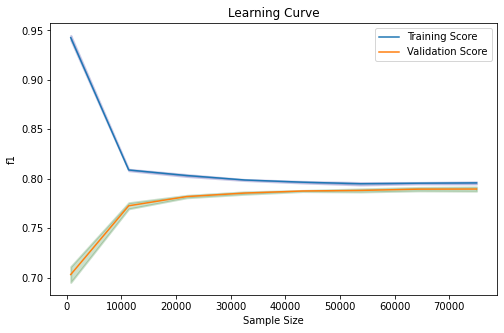

Training scores:

                cv1       cv2       cv3       cv4
0.010000  0.946695  0.941176  0.941176  0.941176
0.151429  0.807452  0.809259  0.809259  0.809259
0.292857  0.804977  0.802610  0.802610  0.802610
0.434286  0.799177  0.797725  0.798923  0.798923
0.575714  0.797908  0.795829  0.796077  0.796077
0.717143  0.794913  0.793473  0.794276  0.796859
0.858571  0.795552  0.794209  0.796331  0.795729
1.000000  0.797140  0.794296  0.796357  0.795165

 ----------------------------------------------------------------------

Validation scores:

                cv1       cv2       cv3       cv4  mean_score
0.010000  0.716697  0.698017  0.696692  0.700917    0.703081
0.151429  0.777410  0.768869  0.771667  0.772511    0.772614
0.292857  0.782840  0.781533  0.780056  0.783196    0.781906
0.434286  0.784824  0.786440  0.783728  0.786839    0.785458
0.575714  0.787045  0.787102  0.787621  0.788486    0.787563
0.717143  0.786524  0.789302  0.786641  0.789992    0.788115
0.858571  0.787550

In [32]:
from sklearn.model_selection import learning_curve, validation_curve
scoring= 'f1'
cv= 4

ns = np.linspace(.01,1, num=8)
train_sizes, train_scores, valid_scores = learning_curve(clf, X, Y, train_sizes=ns,
                                                         cv=cv, scoring= scoring, n_jobs = -1)

train_scores_mean =  train_scores.mean(axis = 1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean =  valid_scores.mean(axis = 1)
validation_scores_std  = valid_scores.std(axis = 1)

xlabel = 'Sample Size'
ylabel = scoring
plt_title = 'Learning Curve'

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
ax.plot(train_sizes, train_scores_mean, label = 'Training Score')
ax.plot(train_sizes, validation_scores_mean, label = 'Validation Score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkblue", lw=2)
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2,
                 color="darkgreen", lw=2)

plt.legend()
# plt.yscale('log')
plt.show()

print('Training scores:\n\n', pd.DataFrame( train_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns) )
print('\n', '-' * 70) # separator to make the output easy to read
valid_df = pd.DataFrame(valid_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns)
valid_df['mean_score'] = validation_scores_mean
print('\nValidation scores:\n\n',valid_df )

Found the best split of data:

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X, Y, n_samples = 100000, random_state=0) , random_state=0, test_size =.09)

### Validation Curve

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................p_transformer__degree=2; total time=   6.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END ............................p_transformer__degree=3; total time=  22.2s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END ............................p_transformer__degree=4; total time= 1.2min
[CV] END ............................p_transformer__degree=2; total time=   6.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END ............................p_transformer__degree=3; total time=  23.0s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END ............................p_transformer__degree=4; total time= 1.2min
[CV] END ............................p_transformer__degree=2; total time=   6.7s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END ............................p_transformer__degree=3; total time=  21.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END ............................p_transformer__degree=4; total time= 1.1min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  5.0min finished


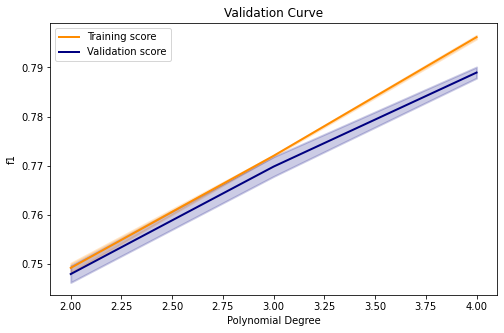

Training scores:

         cv1       cv2       cv3
2  0.747914  0.749962  0.749895
3  0.772137  0.771910  0.772073
4  0.795802  0.796649  0.796000

 ----------------------------------------------------------------------

Validation scores:

         cv1       cv2       cv3  mean_score
2  0.750112  0.747981  0.745932    0.748008
3  0.768351  0.772672  0.768525    0.769849
4  0.789929  0.789556  0.787369    0.788951


In [12]:
cv=3
scoring='f1'
deg_list = [2,3,4]
train_scores, valid_scores = validation_curve(clf, X_train, Y_train, 
                                              param_name='p_transformer__degree',
                                              param_range= deg_list, 
                                              cv=cv, 
                                              scoring = scoring,
                                              verbose=2, 
                                              pre_dispatch=4
                                             )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

xlabel = 'Polynomial Degree'
ylabel = scoring
plt_title = 'Validation Curve'

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
plt.plot(deg_list, train_scores_mean, label="Training score",
                 color="darkorange", lw=2)
plt.fill_between(deg_list, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=2)
plt.plot(deg_list, valid_scores_mean, label="Validation score",
             color="navy", lw=2)
plt.fill_between(deg_list, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=2)
plt.legend(loc="best")
plt.show()

print('Training scores:\n\n', pd.DataFrame(train_scores, columns=[f'cv{i+1}' for i in range(cv)], index=deg_list) )
print('\n', '-' * 70) # separator to make the output easy to read
val_df = pd.DataFrame(valid_scores, columns=[f'cv{i+1}' for i in range(cv)], index=deg_list)
val_df['mean_score'] = valid_scores_mean
print('\nValidation scores:\n\n', val_df )

Larger polynomial degrees could not be tested because of the RAM limit.

### Classification Report 
Print some information about the trained model such as training time, ... 

In [16]:
from sklearn.metrics import classification_report

# deg = 4

# lrg = LogisticRegression(fit_intercept=True, penalty='l2', max_iter=400, C=.1, tol=.001, solver='lbfgs')
# clf = Pipeline([('scaler', StandardScaler() ), 
#                         ('p_transformer', PolynomialFeatures(degree = deg)), 
#                         ('clf', lrg)])
start = time.time()
trained_model = clf.fit(X_train,Y_train)
runtime_train = time.time() - start

### Testing the model

start = time.time()
Y_pred = trained_model.predict(X_test)
runtime_pred = time.time() - start
out_error = np.abs(Y_test - Y_pred).sum() / len(Y_test)

in_error = np.abs(Y_train - trained_model.predict(X_train)  ).sum() / len(Y_train)

f1 = f1_score(Y_test, Y_pred, average='macro')

print(f'The in-sample error is {in_error:.4f}, and the out_sample error is {out_error:.4f}.')
print(f'The out_sample f1 score is {f1}\n\n')

clf_report = classification_report(Y_test, Y_pred)
print(clf_report)

EM1 = scoring
CVS1 = f1_score(Y_train, clf.predict(X_train))
CPS1 = f1_score(Y_test, Y_pred)
T1 = runtime_train
PT1 = runtime_pred
print( "Training Time was: " + str(T1))
print("Prediction Time was: " + str(PT1))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


The in-sample error is 0.2381, and the out_sample error is 0.2389.
The out_sample f1 score is 0.756052618202151


              precision    recall  f1-score   support

           0       0.75      0.69      0.72      4023
           1       0.77      0.82      0.79      4977

    accuracy                           0.76      9000
   macro avg       0.76      0.75      0.76      9000
weighted avg       0.76      0.76      0.76      9000

Training Time was: 105.43305134773254
Prediction Time was: 0.17873215675354004


### Confusion Matrix

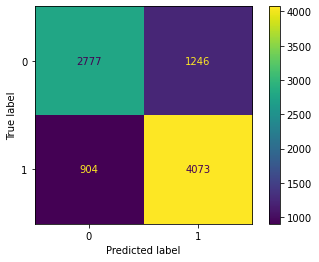

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

# Logistic Regression / CDM

Training a linear logistic regression with intercepts on a 1st degree polynpmial of sample data, in pipeline.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

deg = 3

lrg = LogisticRegression(fit_intercept=True, penalty='l2', max_iter=300, C = 1, tol=.01, solver='lbfgs')
clf = Pipeline([('scaler', StandardScaler() ), 
                        ('p_transformer', PolynomialFeatures(degree = deg)), 
                        ('clf', lrg)])

clf.fit(X2_train, Y2_train)
Y_predict = clf.predict(X2_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
# F1 score on the test set
from sklearn.metrics import f1_score

f1_score(Y_test, Y_predict, average='macro')

0.7292486713109956

### Fine Tuning The Hyperparameter

In [ ]:
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'p_transformer', 'clf', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'p_transformer__degree', 'p_transformer__include_bias', 'p_transformer__interaction_only', 'p_transformer__order', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__l1_ratio', 'clf__max_iter', 'clf__multi_class', 'clf__n_jobs', 'clf__penalty', 'clf__random_state', 'clf__solver', 'clf__tol', 'clf__verbose', 'clf__warm_start'])

In [ ]:
from sklearn.model_selection import GridSearchCV

# deg_list = [1,2,3]

tol = np.logspace(-3,-1, num=3)

# penalty = ['l1', 'l2']

# class_weight = [{0: 5, 1:1}, {0: 3, 1:1}, None]

C = [.1,1]

solver = ['lbfgs', 'saga']

random_grid_lrg = {
                # 'clf__class_weight': class_weight,
                'clf__solver': solver,
                # 'p_transformer__degree' : deg_list,
                'clf__C': C,
                'clf__tol': tol
                  }

print(random_grid_lrg)

{'clf__solver': ['lbfgs', 'saga'], 'clf__C': [0.1, 1], 'clf__tol': array([0.001, 0.01 , 0.1  ])}


In [ ]:
scoring = 'f1'
best_params= []
print('start')

lrg_grid = GridSearchCV(estimator = clf, param_grid = random_grid_lrg, scoring= scoring, cv = 4, verbose=2, pre_dispatch=2)


lrg_grid.fit(X2_train, Y2_train)

best_params += [lrg_grid.best_params_]
print(best_params)

In [ ]:
# Other best_params we got:
# accuracy:
## {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'saga', 'p_transformer__degree': 1}
## {'clf__C': 1, 'clf__solver': 'liblinear', 'p_transformer__degree': 1}
## {'clf__C': 0.1,'clf__class_weight': None,'clf__solver': 'liblinear','p_transformer__degree': 1}
#  f1:
## [{'clf__C': 0.1, 'clf__solver': 'lbfgs', 'clf__tol': 0.001}]
## [{'clf__C': 1, 'clf__class_weight': {0: 1, 1: 3}, 'clf__solver': 'lbfgs', 'p_transformer__degree': 2}]
## {'clf__C': 1, 'clf__class_weight': {0: 1, 1: 5}, 'clf__solver': 'liblinear', 'p_transformer__degree': 1}

Best Model:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
deg = 4

lrg = LogisticRegression(fit_intercept=True, penalty='l2', max_iter=400, C=.1, tol=.001, solver='lbfgs')
clf = Pipeline([('scaler', StandardScaler() ), 
                        ('p_transformer', PolynomialFeatures(degree = deg)), 
                        ('clf', lrg)])

In [ ]:
clf.fit(X2_train, Y2_train)
Y_predict = clf.predict(X2_test)

# F1 score on the test set
from sklearn.metrics import f1_score
f1_score(Y2_test, Y2_predict, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.7542484503763625

### Learning Curve

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


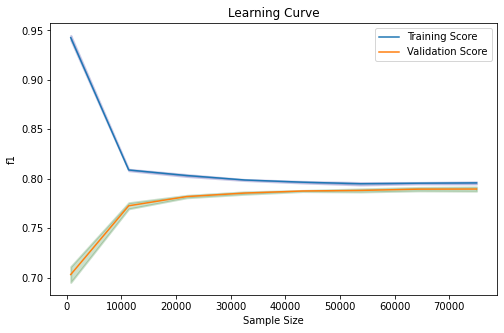

Training scores:

                cv1       cv2       cv3       cv4
0.010000  0.946695  0.941176  0.941176  0.941176
0.151429  0.807452  0.809259  0.809259  0.809259
0.292857  0.804977  0.802610  0.802610  0.802610
0.434286  0.799177  0.797725  0.798923  0.798923
0.575714  0.797908  0.795829  0.796077  0.796077
0.717143  0.794913  0.793473  0.794276  0.796859
0.858571  0.795552  0.794209  0.796331  0.795729
1.000000  0.797140  0.794296  0.796357  0.795165

 ----------------------------------------------------------------------

Validation scores:

                cv1       cv2       cv3       cv4  mean_score
0.010000  0.716697  0.698017  0.696692  0.700917    0.703081
0.151429  0.777410  0.768869  0.771667  0.772511    0.772614
0.292857  0.782840  0.781533  0.780056  0.783196    0.781906
0.434286  0.784824  0.786440  0.783728  0.786839    0.785458
0.575714  0.787045  0.787102  0.787621  0.788486    0.787563
0.717143  0.786524  0.789302  0.786641  0.789992    0.788115
0.858571  0.787550

In [ ]:
from sklearn.model_selection import learning_curve, validation_curve
scoring= 'f1'
cv= 4

ns = np.linspace(.01,1, num=8)
train_sizes, train_scores, valid_scores = learning_curve(clf, X2, Y2, train_sizes=ns,
                                                         cv=cv, scoring= scoring, n_jobs = -1)

train_scores_mean =  train_scores.mean(axis = 1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean =  valid_scores.mean(axis = 1)
validation_scores_std  = valid_scores.std(axis = 1)

xlabel = 'Sample Size'
ylabel = scoring
plt_title = 'Learning Curve'

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
ax.plot(train_sizes, train_scores_mean, label = 'Training Score')
ax.plot(train_sizes, validation_scores_mean, label = 'Validation Score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkblue", lw=2)
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2,
                 color="darkgreen", lw=2)

plt.legend()
# plt.yscale('log')
plt.show()

print('Training scores:\n\n', pd.DataFrame( train_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns) )
print('\n', '-' * 70) # separator to make the output easy to read
valid_df = pd.DataFrame(valid_scores, columns=[f'cv{i+1}' for i in range(cv)], index=ns)
valid_df['mean_score'] = validation_scores_mean
print('\nValidation scores:\n\n',valid_df )

Found the best split of data:

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X, Y, n_samples = 100000, random_state=0) , random_state=0, test_size =.09)

### Validation Curve

In [ ]:
cv=4
scoring='f1'
deg_list = [3,5,7,10]
train_scores, valid_scores = validation_curve(clf, X2_train, Y2_train, 
                                              param_name='p_transformer__degree',
                                              param_range= deg_list, 
                                              cv=cv, 
                                              scoring = scoring,
                                              verbose=2, 
                                              pre_dispatch=2
                                             )
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

xlabel = 'Polynomial Degree'
ylabel = scoring
plt_title = 'Validation Curve'

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
plt.plot(deg_list, train_scores_mean, label="Training score",
                 color="darkorange", lw=2)
plt.fill_between(deg_list, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=2)
plt.plot(deg_list, valid_scores_mean, label="Validation score",
             color="navy", lw=2)
plt.fill_between(deg_list, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=2)
plt.legend(loc="best")
plt.show()

print('Training scores:\n\n', pd.DataFrame(train_scores, columns=[f'cv{i+1}' for i in range(cv)], index=deg_list) )
print('\n', '-' * 70) # separator to make the output easy to read
val_df = pd.DataFrame(valid_scores, columns=[f'cv{i+1}' for i in range(cv)], index=deg_list)
val_df['mean_score'] = valid_scores_mean
print('\nValidation scores:\n\n', val_df )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END ............................p_transformer__degree=3; total time=  26.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.0s remaining:    0.0s


### Classification Report 
Print some information about the trained model such as training time, ... 

In [ ]:
from sklearn.metrics import classification_report

deg = 1

lrg = LogisticRegression(fit_intercept=True, penalty='l2', max_iter=400, C=1, tol=.005, class_weight ={0: 1, 1: 5}, solver='liblinear')
clf = Pipeline([('scaler', StandardScaler() ), 
                        ('p_transformer', PolynomialFeatures(degree = deg)), 
                        ('clf', lrg)])
start = time.time()
trained_model = clf.fit(X2_train,Y2_train)
runtime_train = time.time() - start

### Testing the model

start = time.time()
Y_pred = trained_model.predict(X_test)
runtime_pred = time.time() - start
out_error = np.abs(Y_test - Y_pred).sum() / len(Y_test)

in_error = np.abs(Y_train - trained_model.predict(X_train)  ).sum() / len(Y_train)

f1 = f1_score(Y_test, Y_pred, average='macro')

print(f'The in-sample error is {in_error:.4f}, and the out_sample error is {out_error:.4f}.')
print(f'The out_sample f1 score is {f1}\n\n')

clf_report = classification_report(Y_test, Y_pred)
print(clf_report)

EM1 = scoring
CVS1 = f1_score(Y_train, clf.predict(X_train))
CPS1 = f1_score(Y_test, Y_pred)
T1 = runtime_train
P1 = runtime_pred
print( "Training Time was: " + str(T1))
print("Prediction Time was: " + str(PT1))

The in-sample error is 0.1735, and the out_sample error is 0.1721.
The out_sample f1 score is 0.677215446175149


              precision    recall  f1-score   support

           0       0.95      0.85      0.90      7978
           1       0.36      0.64      0.46      1022

    accuracy                           0.83      9000
   macro avg       0.65      0.74      0.68      9000
weighted avg       0.88      0.83      0.85      9000

Training Time was: 0.18645167350769043
Prediction Time was: 0.0020079612731933594


### Confusion Matrix

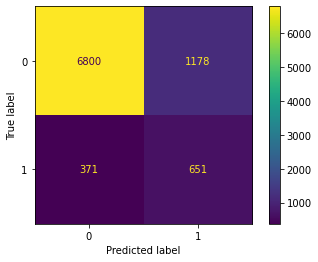

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, Y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

A table is created to compare the five recently-traind models above. It includes evaluation metric(s), training time and prediction time of each models. Also, we sorted models based on their performance from different aspects. 

# Comparing Models

In [ ]:
table = pd.DataFrame({'Name':['Neutrino','CDM'],
                        'Evaluation Metric(s)': [EM1, EM2],
                        'Corresponding Validation Score': [CVS1, CVS2],
                        'Corresponding Prediction Score':  [CPS1, CPS2],
                        'Training Time': [T1, T2],
                        'Prediction Time': [PT1, PT2]
})

print('Sort models based on their validation scores: \n' + str(table.sort_values(by=['Corresponding Validation Score'], ascending= False).loc[:, ['Name', 'Corresponding Validation Score']]))
print('\nSort models based on their prediction scores: \n' + str(table.sort_values(by=['Corresponding Prediction Score'], ascending= False).loc[:, ['Name', 'Corresponding Prediction Score']]))
print('\nSort models based on their training time: \n' + str(table.sort_values(by=['Training Time'], ascending= True).loc[:, ['Name', 'Training Time']]))
print('\nSort models based on their prediction time: \n' + str(table.sort_values(by=['Prediction Time'], ascending= True).loc[:, ['Name', 'Prediction Time']]))
